In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import pearsonr
import individual_prediction
import gene_prediction
import part1_normalize_predictions

# Running Enformer for Inividual Prediction

In [ ]:
predictions = individual_prediction.run_enformer("GTEX-1JMQI")

In [10]:
predictions = pd.read_pickle('./data_/sum_stats_GTEX-1JMQI')
predictions

,output,true,mean_prediction,gene_exp_tracks,blood_mean
0,"[[0.084296055, 0.08817325, 0.10868081, 0.08987...",0.706494,1.001050,0.072144,0.094448
1,"[[0.079454444, 0.08264593, 0.10211448, 0.08053...",1.382185,0.946958,0.074200,0.085729
2,"[[0.0372191, 0.036553897, 0.028942728, 0.05171...",0.433461,0.726118,0.030193,0.054167
3,"[[0.10508142, 0.112968825, 0.1411426, 0.095036...",-1.442962,1.004281,0.240938,0.327627
4,"[[0.18740812, 0.18950415, 0.23729949, 0.127890...",-1.396898,1.161463,0.303934,0.470002
...,...,...,...,...,...
569,"[[0.32434317, 0.35366538, 0.48401946, 0.182931...",-0.462371,1.438412,0.329137,0.317762
570,"[[0.28047597, 0.3232522, 0.44591138, 0.1704778...",1.034199,1.359313,0.438184,0.319138
571,"[[0.30443397, 0.3588802, 0.5324826, 0.1694706,...",-0.445806,1.295028,0.306191,0.214336
572,"[[0.19074407, 0.21617892, 0.3565924, 0.0997722...",1.015253,0.684483,0.109743,0.078812


# Transforming Enformer Output

In [11]:
files = ['./data_/sum_stats_gtex111ys.pkl', './data_/sum_stats_gtex113jc', \
          './data_/sum_stats_gtex117xs.pkl', './data_/sum_stats_gtexzvt4', \
          './data_/sum_stats_gtexrws6.pkl']
true, predict_mean = part1_normalize_predictions.transform(files)

# Fitting Stacked Model

In [12]:
X_train = predict_mean.iloc[:,1:].values.T
y_train = true.iloc[:,1:].values.T

X_test = predict_mean[['0']].values.T
y_test = true[['0']].values.T

## Ridge Regression

In [13]:
ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_cv = GridSearchCV(ridge, param_grid, scoring='r2', cv=2)
ridge_cv.fit(X_train, y_train)

best_alpha = ridge_cv.best_params_['alpha']
best_ridge_model = ridge_cv.best_estimator_

print(f"Best Alpha for Ridge: {best_alpha}")

Best Alpha for Ridge: 0.001


In [14]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)

ridge_preds = ridge.predict(X_test)

## Random Forest Regressor

In [15]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(rf, param_grid, scoring='r2', cv=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf_params = rf_grid.best_params_
best_rf_model = rf_grid.best_estimator_

print(f"Best Parameters for Random Forest: {best_rf_params}")

Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [16]:
rf = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

## Polynomial

In [17]:
poly_model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=0.1))
poly_model.fit(X_train, y_train)
poly_adjusted_predictions = poly_model.predict(X_test)

## Elastic Net

In [18]:
elastic_net = ElasticNet()
elastic_net_param_grid = {'alpha': np.logspace(-3, 3, 50), 'l1_ratio': np.linspace(0.1, 0.9, 10)}
elastic_net_search = RandomizedSearchCV(elastic_net, elastic_net_param_grid, n_iter=20, scoring='r2', cv=2, random_state=42)
elastic_net_search.fit(X_train, y_train)
elastic_net_best = elastic_net_search.best_estimator_
print(f"Best Parameters for Elastic Net: {elastic_net_search.best_params_}")

Best Parameters for Elastic Net: {'l1_ratio': np.float64(0.1), 'alpha': np.float64(0.002329951810515372)}


In [19]:
elastic_net = ElasticNet(alpha=0.002329951810515372, l1_ratio=0.1)
elastic_net.fit(X_train, y_train)
pred_elastic_net = elastic_net.predict(X_test)

## Stacked Model

In [20]:
stack_train = np.column_stack((
    ridge.predict(X_train), 
    rf.predict(X_train), 
    poly_model.predict(X_train), 
    elastic_net.predict(X_train)
))

stack_test = np.column_stack((
    ridge.predict(X_test), 
    rf.predict(X_test),
    poly_model.predict(X_test),
    elastic_net.predict(X_test)
))

In [21]:
meta_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.005,
    max_depth=5,
    subsample=0.7,         
    colsample_bytree=0.7, 
    colsample_bylevel=0.8, 
    reg_lambda=1,    
    reg_alpha=0.5, 
    random_state=None      
)
meta_model.fit(stack_train, y_train)
stacked_pred = meta_model.predict(stack_test)
stacked_score = pearsonr(y_test.flatten(), stacked_pred.flatten())[0]
print(f"Stacked Model Pearson Correlation: {stacked_score:.4f}")

Stacked Model Pearson Correlation: -0.3030


In [22]:
p_value = pearsonr(y_test.flatten(), stacked_pred.flatten())[1]

In [23]:
p_value

np.float64(1.181424274747606e-13)

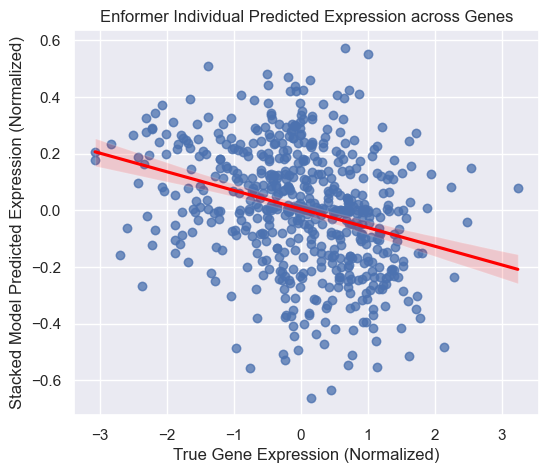

In [29]:
sns.set(font_scale=1)
plt.figure(figsize=(6,5))
plt.scatter(y_test.flatten(), stacked_pred.flatten(), alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Stacked Model Predicted Expression (Normalized)")
plt.title(f"Enformer Individual Predicted Expression across Genes")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
sns.regplot(x=y_test, y=stacked_pred, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.show()

# Enformer for Gene Prediction

In [ ]:
predictions = gene_prediction.run_enformer('ENSG00000167077.12')

In [3]:
predictions = pd.read_pickle('./data_/sum_stats_gene447')
results = predictions[['true', 'mean_prediction']]

In [5]:
normalized = part1_normalize_predictions.quantile_normalize(results)

In [7]:
corr, p_value = pearsonr(normalized['mean_prediction'], normalized["true"])
corr

np.float64(0.22133664830156255)

**see `gtex_prs` for comparison between PRS**